In [24]:
import numpy as np
from os import path, makedirs
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [14]:

#load output cross-val validation data
outputs_validation = np.empty(shape=0)
outputs_training = np.empty(shape=0)
labels_validation = np.empty(shape=0,dtype=np.int32)
labels_training = np.empty(shape=0,dtype=np.int32)
fixations_validation = np.empty(shape=0,dtype=np.int32)
fixations_training = np.empty(shape=0,dtype=np.int32)
scanpath_ids_validation = np.empty(shape=0,dtype=np.int32)
scanpath_ids_training = np.empty(shape=0,dtype=np.int32)

model_class="TransferNet"

if not path.exists(f'{model_class}_figures'):   
   makedirs(f'{model_class}_figures')

for i in range(1,6):
    dict = np.load(path.abspath(f"{model_class}-outputs-{i}.npz"))
    outputs_training = np.append(outputs_training,dict["outputs_training"])
    labels_training = np.append(labels_training,dict["labels_training"])    
    fixations_training = np.append(fixations_training,dict["fixations_training"])
    scanpath_ids_training = np.append(scanpath_ids_training,dict["scanpath_ids_training"])
    outputs_validation = np.append(outputs_validation,dict["outputs_validation"])
    labels_validation = np.append(labels_validation,dict["labels_validation"])    
    fixations_validation = np.append(fixations_validation,dict["fixations_validation"])
    scanpath_ids_validation = np.append(scanpath_ids_validation,dict["scanpath_ids_validation"])
outputs_validation = outputs_validation.reshape(-1,4)
outputs_training = outputs_training.reshape(-1,4)


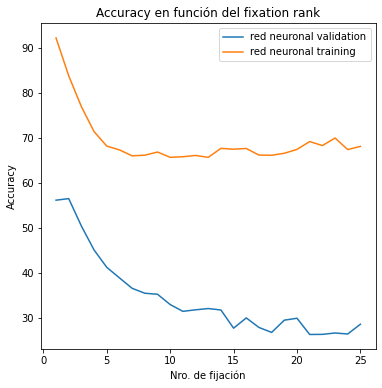

In [19]:


fig, ax = plt.subplots(1, 1, figsize = (6,6))

#accuracy por número de fijación

indexes_by_fix_number = []
acc_by_fix = np.empty(shape=(0,))


for j in range(1,26):
    indexes_by_fix_number.append(np.where(fixations_validation == j)[0])
for array in indexes_by_fix_number:
    outputs_by_fix = outputs_validation[array]
    labels_by_fix = labels_validation[array]
    predictions_by_fix = np.argmax(outputs_by_fix,1)
    total = labels_by_fix.shape[0]
    correct = np.sum(predictions_by_fix == labels_by_fix)
    
    acc_by_fix = np.append(acc_by_fix,100.0 * correct / total)

ax.plot(range(1,26),acc_by_fix,label="red neuronal validation")




indexes_by_fix_number = []
acc_by_fix = np.empty(shape=(0,))



for j in range(1,26):
    indexes_by_fix_number.append(np.where(fixations_training == j)[0])
for array in indexes_by_fix_number:
    outputs_by_fix = outputs_training[array]
    labels_by_fix = labels_training[array]
    predictions_by_fix = np.argmax(outputs_by_fix,1)
    total = labels_by_fix.shape[0]
    correct = np.sum(predictions_by_fix == labels_by_fix)    

    acc_by_fix = np.append(acc_by_fix,100.0 * correct / total)

ax.plot(range(1,26),acc_by_fix,label="red neuronal training")
ax.set_title(f"Accuracy en función del fixation rank")
ax.set_xlabel("Nro. de fijación")
ax.set_ylabel("Accuracy")

ax.legend()
fig.savefig(f'{model_class}_figures/statistics_fixation_rank.png');


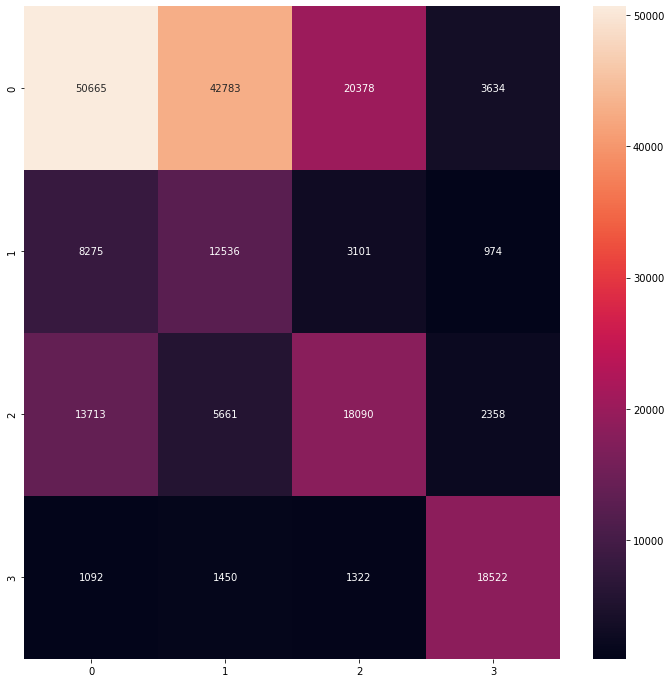

In [33]:
#confusion matrix
predictions = np.argmax(outputs_validation,1)
conf_mat = confusion_matrix(labels_validation, predictions)
fig, ax = plt.subplots(1, 1, figsize = (12,12))
sns.heatmap(conf_mat, annot=True,ax=ax, fmt='g')

#clase 3: encontré el target (target present + última fijación)
#clase 2: no encontré el target (target present + fijación anterior a la última)
#clase 1: detuve la búsqueda (target absent + última fijación)
#clase 0: continúo buscando (target absent + fijación anterior a la última)

#Filas: clase verdadera
#Columnas: clase predicha
fig.savefig(f'{model_class}_figures/Confusion_Matrix.png')

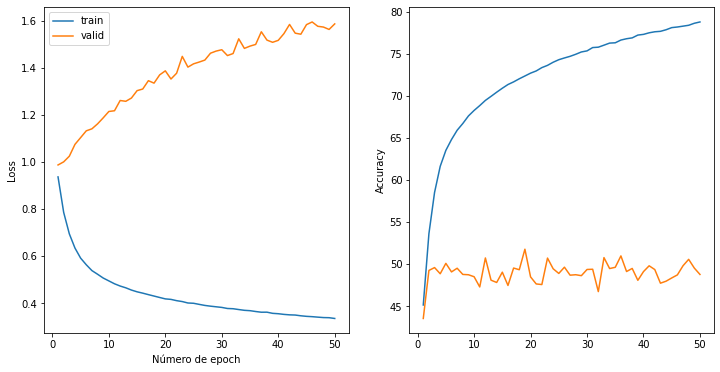

In [28]:
cross_val_data = pd.read_csv(f"training_info_{model_class}.csv")
training_data = cross_val_data[cross_val_data["train"] == 1].groupby("n_epoch").mean()[["acc","loss"]]
validation_data = cross_val_data[cross_val_data["valid"] == 1].groupby("n_epoch").mean()[["acc","loss"]]

fig, ax = plt.subplots(1, 2, figsize = (12,6))
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")


ax[0].set_xlabel("Número de epoch")
ax[0].plot(training_data['loss'])
ax[1].plot(training_data['acc'])
ax[0].plot(validation_data['loss'])
ax[1].plot(validation_data['acc'])



ax[0].legend(["train","valid"]);
fig.savefig(f'{model_class}_figures/training_statistics.png')

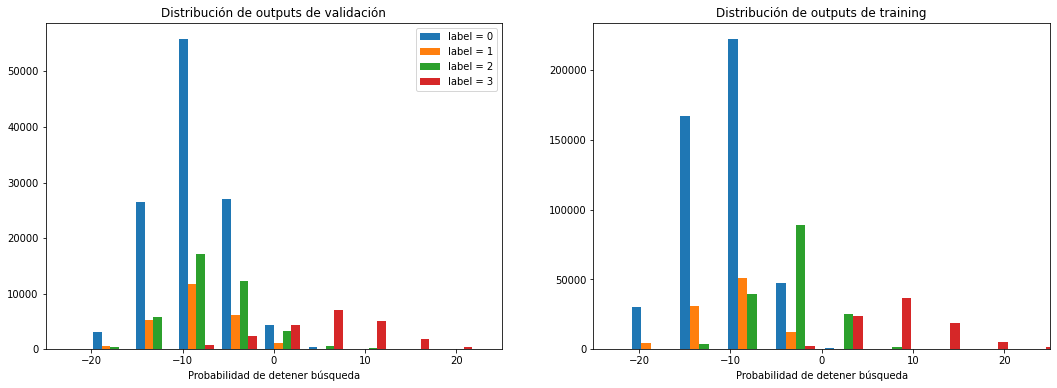

In [44]:
#acá quería ver si usando el posterior de la clase 3 podía de alguna forma obtener un valor de "confianza", para decidir entre dejar de buscar, continuar o encontré el target. Pero como la clase 0 y 1 no tienen separación aparente, no se puede.

posteriorsClase3Validation = outputs_validation[:,3]
posteriorsClase3Training= outputs_training[:,3]

fig, ax = plt.subplots(1, 2, figsize = (18,6),sharex=True)
ax[0].set_title(f"Distribución de outputs de validación")
ax[0].set_xlabel("Probabilidad de detener búsqueda")
ax[1].set_title(f"Distribución de outputs de training")
ax[1].set_xlabel("Probabilidad de detener búsqueda")
ax[1].set_xlim(-25,25)
val_labels_hist = []
training_labels_hist = []

for i in range(0,4):
    val_labels_hist.append(posteriorsClase3Validation[np.where(labels_validation == i)[0]])
    training_labels_hist.append(posteriorsClase3Training[np.where(labels_training == i)[0]])

ax[0].hist(val_labels_hist, 15, label=['label = 0', 'label = 1','label = 2', 'label = 3'])
ax[1].hist(training_labels_hist, 20, label=['label = 0', 'label = 1','label = 2', 'label = 3'])
ax[0].legend(loc='upper right')
fig.savefig(f'{model_class}_figures/Posteriors_clase3_por_label.png');

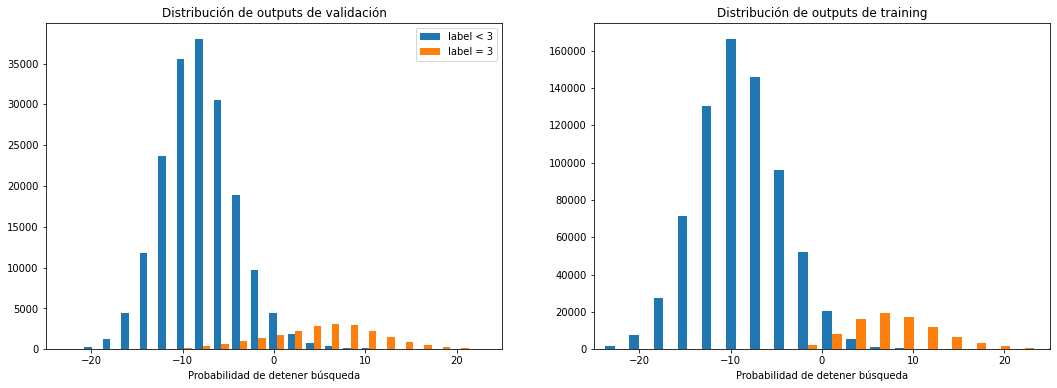

In [46]:
posteriorsClase3Validation = outputs_validation[:,3]
posteriorsClase3Training= outputs_training[:,3]

fig, ax = plt.subplots(1, 2, figsize = (18,6),sharex=True)
ax[0].set_title(f"Distribución de outputs de validación")
ax[0].set_xlabel("Probabilidad de detener búsqueda")
ax[1].set_title(f"Distribución de outputs de training")
ax[1].set_xlabel("Probabilidad de detener búsqueda")
ax[1].set_xlim(-25,25)
val_labels_hist = []
training_labels_hist = []

val_labels_hist.append(posteriorsClase3Validation[np.where(labels_validation != 3)[0]])
training_labels_hist.append(posteriorsClase3Training[np.where(labels_training != 3)[0]])
val_labels_hist.append(posteriorsClase3Validation[np.where(labels_validation == 3)[0]])
training_labels_hist.append(posteriorsClase3Training[np.where(labels_training == 3)[0]])

ax[0].hist(val_labels_hist, 35, label=['label < 3', 'label = 3'])
ax[1].hist(training_labels_hist, 40, label=['label < 3', 'label = 3'])
ax[0].legend(loc='upper right')
fig.savefig(f'{model_class}_figures/Posteriors_clase3_por_label_acumulado.png');